# Assignment 9: GBDT

#### Response Coding: Example

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re

import pickle
from tqdm import tqdm
import os


from collections import Counter

In [3]:
#please use below code to load glove vectors 
import pickle
with open('/content/drive/MyDrive/Random_Forest/11_Donors_choose_GBDT/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [4]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [6]:
train_data = pd.read_csv('/content/drive/MyDrive/Random_Forest/11_Donors_choose_GBDT/train_data.csv')
resource_data = pd.read_csv('/content/drive/MyDrive/Random_Forest/11_Donors_choose_GBDT/resources.csv')

## 1.1.1 Preprocessing Data

### **1.1.2 Preprocessing of project_subject_categories**


In [7]:
catogories = list(train_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python
catogories_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    catogories_list.append(temp.strip())
    
train_data['clean_categories'] = catogories_list
train_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in train_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### **1.1.3 Preprocessing of project_subject_subcategories**


In [8]:
sub_catogories = list(train_data['project_subject_subcategories'].values)

sub_catogories_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_catogories_list.append(temp.strip())

train_data['clean_subcategories'] = sub_catogories_list
train_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in train_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


### **1.1.4 Preprocessing of project grade categories**


In [9]:
print(train_data['project_grade_category'].values[0])
print("*"*50)
print(train_data['project_grade_category'].values[150])
print("*"*50)
print(train_data['project_grade_category'].values[1000])
print("*"*50)


train_data['project_grade_category'].value_counts()

Grades PreK-2
**************************************************
Grades 3-5
**************************************************
Grades 3-5
**************************************************


Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [10]:
preprocessed_project_grade_categories= []

for grade_cat in tqdm(train_data["project_grade_category"]):
   
    grade_cat = grade_cat.replace('-', '_')  #Replacing(-) with(_)
    grade_cat = grade_cat.replace('Grades', '') #Removing grades as it is redundant
   
    grad_cat = ' '.join(f for f in grade_cat.split())
    preprocessed_project_grade_categories.append(grad_cat.strip())

100%|██████████| 109248/109248 [00:00<00:00, 562692.12it/s]


### **1.1.5 Preprocessing of teacher prefix**


In [11]:
train_data['teacher_prefix'] = train_data['teacher_prefix'].fillna('null')


In [12]:

def replace_cate(lst):          # Removing (.) in Mrs. 
    return lst.replace('.','')
   

train_data['teacher_prefix']= train_data['teacher_prefix'].astype(str).apply(replace_cate)

### **1.1.6 Adding a new feature Number of words in title**


In [13]:
title_word_count = []
for a in train_data["project_title"] :
    b = len(a.split())
    title_word_count.append(b)

In [14]:
train_data["title_word_count"] = title_word_count
train_data.head(2)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,title_word_count
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,7
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,5


### **1.1.7 Merging 4 essays into single essay**

In [15]:
train_data["essay"] = train_data["project_essay_1"].map(str) +\
                        train_data["project_essay_2"].map(str) + \
                        train_data["project_essay_3"].map(str) + \
                        train_data["project_essay_4"].map(str)

### **1.1.8 Adding a new feature Number of words in essay**

In [16]:
essay_word_count=[]
for ess in train_data["essay"] :
    c = len(ess.split())
    essay_word_count.append(c)

In [17]:
train_data["essay_word_count"] = essay_word_count
train_data.head(2)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,title_word_count,essay,essay_word_count
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,7,My students are English learners that are work...,272
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,5,Our students arrive to our school eager to lea...,221


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [18]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, train_data['project_is_approved'], test_size=0.33, stratify = train_data['project_is_approved'],random_state=0)


In [19]:
#Dropping Class label
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)


In [20]:
X_train.head(2)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,title_word_count,essay,essay_word_count
25553,35717,p067777,5b87ff6fd3652c7a964b63efbf74a889,Ms,CA,2016-11-05 23:37:37,Grades 6-8,Opening the World of Programming,I wake up everyday and drive one hour each way...,Providing my student with Arduino Starter Kits...,NaN,NaN,My students need 13 Arduino Starter Kits so th...,0,Math_Science,AppliedSciences,5,I wake up everyday and drive one hour each way...,314
55121,151876,p141227,29f0984eab0a7042b70125b226b36bea,Mrs,RI,2016-11-21 08:51:53,Grades 6-8,New ways to learn,My students are new to junior high school and...,Learning on an iPad will expose many students ...,NaN,NaN,My students need exposure to more technology. ...,1,Literacy_Language,Literature_Writing,4,My students are new to junior high school and...,199


### **1.2.1 Preprocessesing training data - Text**



In [21]:
print(X_train['essay'].values[260])
print("*"*50)
print(X_train['essay'].values[3000])
print("*"*50)

My students are in a 12:1:1 classroom.  They have been together for 5 years and are getting ready to graduate from elementary school next year.  My students are all learning disabled but full of energy and excitement.   They are well-behaved and love science and math.  Our school is a Title I school with EVERY student receiving free lunch.  \r\n\r\nLearning disabilities do not keep my students from achieving their goals.  They work extra hard to keep up and they enjoy learning new topics.My students thought long and hard about what would get them up and moving and they came up with-VIDEO GAMES!  Like all kids, my students love video games.  When it is raining outside, they would love to have indoors recess, but we do not have a large classroom.  They came up with the idea of using a Wii console to get moving and active.  We would love to play Wii Sports against one another, dance with Just Dance or chill out and learn new yoga moves.  These games will get kids moving, while incorporati

In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
val = decontracted(X_train['essay'].values[5])
print(val)
print("*"*50)

I teach art to students in pre-k through 2nd grade.Each day around 140 students come into my art room. I strive to offer as many mediums,techniques and processes as possible in the small time frame I have as art is only offered once a week to each student.My students are totally uninhibited and this is why I love teaching at the primary level! They are excited and eager to learn. It warms my heart to see them smile as they enter my room and sometimes yell from the hall as they approach,\"What are we doing today in art?\" No task is too difficult for these precious artists and I  delight in seeing the creations that leave my art room!!!!My school was built in the 1950 is so needless to say, it is old! It is located in a small,rural town .Many of my students are poor and do not have much at home in the way of art supplies so I want their experience in my room to be exciting and the materials good quality so they will last.My students will use the canvases and paints for paintings each cl

In [24]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
val = val.replace('\\r', ' ')
val = val.replace('\\"', ' ')
val = val.replace('\\n', ' ')
print(val)

I teach art to students in pre-k through 2nd grade.Each day around 140 students come into my art room. I strive to offer as many mediums,techniques and processes as possible in the small time frame I have as art is only offered once a week to each student.My students are totally uninhibited and this is why I love teaching at the primary level! They are excited and eager to learn. It warms my heart to see them smile as they enter my room and sometimes yell from the hall as they approach, What are we doing today in art?  No task is too difficult for these precious artists and I  delight in seeing the creations that leave my art room!!!!My school was built in the 1950 is so needless to say, it is old! It is located in a small,rural town .Many of my students are poor and do not have much at home in the way of art supplies so I want their experience in my room to be exciting and the materials good quality so they will last.My students will use the canvases and paints for paintings each clas

In [25]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
val = re.sub('[^A-Za-z0-9]+', ' ', val)
print(val)

I teach art to students in pre k through 2nd grade Each day around 140 students come into my art room I strive to offer as many mediums techniques and processes as possible in the small time frame I have as art is only offered once a week to each student My students are totally uninhibited and this is why I love teaching at the primary level They are excited and eager to learn It warms my heart to see them smile as they enter my room and sometimes yell from the hall as they approach What are we doing today in art No task is too difficult for these precious artists and I delight in seeing the creations that leave my art room My school was built in the 1950 is so needless to say it is old It is located in a small rural town Many of my students are poor and do not have much at home in the way of art supplies so I want their experience in my room to be exciting and the materials good quality so they will last My students will use the canvases and paints for paintings each class will create

In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [27]:
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentence in tqdm(X_train['essay'].values):
    val = ' '.join(e for e in val.split() if e.lower() not in stopwords)
    val = decontracted(sentence)
    val = val.replace('\\r', ' ')
    val = val.replace('\\"', ' ')
    val = val.replace('\\n', ' ')
    val = re.sub('[^A-Za-z0-9]+', ' ', val)
   
    preprocessed_essays_train.append(val.lower().strip())

100%|██████████| 73196/73196 [00:46<00:00, 1581.79it/s]


### **1.2.2 Preprocess test data -Text**


In [28]:
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentence in tqdm(X_test['essay'].values):
    val = ' '.join(e for e in val.split() if e.lower() not in stopwords)
    val = decontracted(sentence)
    val = val.replace('\\r', ' ')
    val = val.replace('\\"', ' ')
    val = val.replace('\\n', ' ')
    val = re.sub('[^A-Za-z0-9]+', ' ', val)
    
    preprocessed_essays_test.append(val.lower().strip())

100%|██████████| 36052/36052 [00:22<00:00, 1589.79it/s]


### **1.2.3 preprocessing of project title**


In [29]:
#printing some randomproject titles.
print(train_data['project_title'].values[0])
print("*"*50)
print(train_data['project_title'].values[275])
print("*"*50)
print(train_data['project_title'].values[4000])
print("*"*50)

Educational Support for English Learners at Home
**************************************************
Healthy Snack Attacks
**************************************************
Inspire Summer Reading!
**************************************************


In [30]:
title = decontracted(X_train['project_title'].values[2000])


### **1.2.4 Preprocessing of Project Title-Train**


In [31]:
preprocessed_titles_train = []

for titles in tqdm(X_train["project_title"]):
    title = ' '.join(f for f in title.split() if f not in stopwords)
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    
    preprocessed_titles_train.append(title.lower().strip())

100%|██████████| 73196/73196 [00:02<00:00, 35599.69it/s]


### **1.2.5 Preprocessing of Project Title-Test**


In [32]:
preprocessed_titles_test = []

for titles in tqdm(X_test["project_title"]):
    title = ' '.join(f for f in title.split() if f not in stopwords)
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    
    preprocessed_titles_test.append(title.lower().strip())

100%|██████████| 36052/36052 [00:01<00:00, 35287.44it/s]


In [33]:
preprocessed_titles_test[50]


'getting organized in an alternative seating classroom'

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

## **1.3.1 Vectorizing text data**


### **1.3.1.1 TF-IDF Vectorizer**

### TF-IDF {Essays}

In [34]:
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10) #Considering All features
vectorizer_tfidf_essay.fit(preprocessed_essays_train)

text_tfidf_train = vectorizer_tfidf_essay.transform(preprocessed_essays_train)
text_tfidf_test = vectorizer_tfidf_essay.transform(preprocessed_essays_test)

### TF-IDF {Project_title}

In [35]:
vectorizer_tfidf_titles = TfidfVectorizer(min_df=10)

vectorizer_tfidf_titles.fit(preprocessed_titles_train)
title_tfidf_train = vectorizer_tfidf_titles.transform(preprocessed_titles_train)
title_tfidf_test = vectorizer_tfidf_titles.transform(preprocessed_titles_test)

### **Avg word2vec**{Essay}

In [36]:
# computing average word2vec for each review.
avg_w2v_essays=[]
for sentence in tqdm(preprocessed_essays_train):
    vector=np.zeros(300)
    cnt_wrds=0
    for word in sentence.split(' '):
        if word in glove_words:
            cnt_wrds+=1
            vector+=model[word]
    if cnt_wrds:
            vector/=cnt_wrds
            
    avg_w2v_essays.append(vector)

100%|██████████| 73196/73196 [00:32<00:00, 2255.54it/s]


In [37]:
# average Word2Vec for test essays
# computing average word2vec for each review.
avg_w2v_essays_test=[]
for sentence in tqdm(preprocessed_essays_test):
    vector=np.zeros(300)
    cnt_wrds=0
    for word in sentence.split(' '):
        if word in glove_words:
            cnt_wrds+=1
            vector+=model[word]
    if cnt_wrds:
            vector/=cnt_wrds
            
    avg_w2v_essays_test.append(vector)

100%|██████████| 36052/36052 [00:16<00:00, 2177.97it/s]


### **Avg word2vec**{Project_title}

In [38]:
# average Word2Vec for train titles
# computing average word2vec for each review.
avg_w2v_titles_train=[]
for sentence in tqdm(preprocessed_titles_train):
    vector=np.zeros(300)
    cnt_wrds=0
    for word in sentence.split(' '):
        if word in glove_words:
            cnt_wrds+=1
            vector+=model[word]
    if cnt_wrds:
            vector/=cnt_wrds
            
    avg_w2v_titles_train.append(vector)

100%|██████████| 73196/73196 [00:01<00:00, 65054.48it/s]


In [39]:
# average Word2Vec for test titles
# computing average word2vec for each review.
avg_w2v_titles_test=[]
for sentence in tqdm(preprocessed_titles_test):
    vector=np.zeros(300)
    cnt_wrds=0
    for word in sentence.split(' '):
        if word in glove_words:
            cnt_wrds+=1
            vector+=model[word]
    if cnt_wrds:
            vector/=cnt_wrds
            
    avg_w2v_titles_test.append(vector)

100%|██████████| 36052/36052 [00:00<00:00, 63047.70it/s]


### **weighted tfidf w2v**{Essay}


In [40]:
vec_tfidf_w2v=TfidfVectorizer()
t=vec_tfidf_w2v.fit(preprocessed_essays_train)
dictionary=dict(zip(vec_tfidf_w2v.get_feature_names(),list(vec_tfidf_w2v.idf_)))
tfidf_words=set(vec_tfidf_w2v.get_feature_names())

In [41]:
# average Word2Vec
# compute average word2vec for each review.
def tf_idf_done(word_list):
    train_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(word_list): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split():#.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
              #vec = model.wv[word]  
              vec = model[word] # getting the vector for each word
# here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        train_title_tfidf_w2v_vectors.append(vector)
    print(len(train_title_tfidf_w2v_vectors))
    print(len(train_title_tfidf_w2v_vectors[0]))
    return train_title_tfidf_w2v_vectors

In [42]:
train_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_train)
test_tfidf_w2v_vectors=tf_idf_done(preprocessed_essays_test)


  0%|          | 28/36052 [00:00<02:10, 276.82it/s]

73196
300


100%|██████████| 36052/36052 [02:37<00:00, 228.87it/s]

36052
300


### **weighted tfidf w2v**{Project_title}


In [43]:
train_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_train)
test_title_tfidf_w2v_vectors=tf_idf_done(preprocessed_titles_test)


  5%|▌         | 1849/36052 [00:00<00:01, 18486.27it/s]

73196
300


100%|██████████| 36052/36052 [00:01<00:00, 21358.09it/s]

36052
300


## 1.4 Make Data Model Ready: encoding numerical, categorical features</h2>



## **1.4.1 Vectorizing Numerical features** 

### Various numerical feautures are :

### a).Price

### b).Quantity

### c).Number of Projects previously proposed by Teacher

### d).Essay word Count

### e).Title word Count

### **Price**


In [44]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(6)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4
3,p000004,1113.69,98
4,p000005,485.99,8
5,p000006,130.62,5


In [45]:
# join two dataframes in python: 
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')


In [46]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(1,-1))

price_train = normalizer.transform(X_train['price'].values.reshape(1,-1))
price_test = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
print(price_test.shape, y_test.shape)
print("*"*100)

After vectorizations
(1, 73196) (73196,)
(1, 36052) (36052,)
****************************************************************************************************


### **Quantity**

In [47]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['quantity'].values.reshape(1,-1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape)
print(quantity_test.shape, y_test.shape)
print("*"*100)

After vectorizations
(1, 73196) (73196,)
(1, 36052) (36052,)
****************************************************************************************************


### **Projects previously proposed by Teacher**

In [48]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

prev_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_train.shape, y_train.shape)
print(prev_projects_test.shape, y_test.shape)
print("*"*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)
****************************************************************************************************


### **Title word count**


In [49]:
normalizer = Normalizer()

normalizer.fit(X_train['title_word_count'].values.reshape(1,-1))

title_word_count_train = normalizer.transform(X_train['title_word_count'].values.reshape(1,-1))
title_word_count_test = normalizer.transform(X_test['title_word_count'].values.reshape(1,-1))

print("After vectorizations")
print(title_word_count_train.shape, y_train.shape)
print(title_word_count_test.shape, y_test.shape)
print("*"*100)

After vectorizations
(1, 73196) (73196,)
(1, 36052) (36052,)
****************************************************************************************************


### **Essay word count**


In [50]:
normalizer = Normalizer()

normalizer.fit(X_train['essay_word_count'].values.reshape(1,-1))

essay_word_count_train = normalizer.transform(X_train['essay_word_count'].values.reshape(1,-1))
essay_word_count_test = normalizer.transform(X_test['essay_word_count'].values.reshape(1,-1))

print("After vectorizations")
print(essay_word_count_train.shape, y_train.shape)
print(essay_word_count_test.shape, y_test.shape)

After vectorizations
(1, 73196) (73196,)
(1, 36052) (36052,)


## 1.4.1.1 Reshaping Numerical Features

In [51]:
price_train = (X_train['price'].values.reshape(-1,1))
price_test = (X_test['price'].values.reshape(-1,1))

quantity_train =(X_train['quantity'].values.reshape(-1,1))
quantity_test = (X_test['quantity'].values.reshape(-1,1))

prev_projects_train = (X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = (X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

title_word_count_train = (X_train['title_word_count'].values.reshape(-1,1))
title_word_count_test = (X_test['title_word_count'].values.reshape(-1,1))


essay_word_count_train = (X_train['essay_word_count'].values.reshape(-1,1))
essay_word_count_test = (X_test['essay_word_count'].values.reshape(-1,1))

# **1.4.2 Vectorizing Categorical features(Response Coding)**




### Various Categorical feautures are :

### a).Categories of Projects

### b).Subcategories

### c).School states

### d).Project grade category

### e).Teacher prefix

## 1.4.2.1 Logic For Response Coding, Here Y = 0/1, So we have two new features

In [52]:
from scipy.sparse import coo_matrix

In [53]:
def calculate_proba_score(data, classLabel):
    '''
    Function to return probability score
    
    '''
    positive_score_dict = {}
    negative_score_dict = {}
    distinct_feature = []
    # Collect negative and positive scores of a class label
    for i in range(len(data)):
        # Collect distinct features
        if(data[i] not in distinct_feature):
            distinct_feature.append(data[i])
        if(1 == classLabel.values[i]):
            if(data[i] in positive_score_dict):
                positive_score_dict[data[i]] = positive_score_dict[data[i]] + 1
            else:
                positive_score_dict[data[i]] = 1
        else:
            if(data[i] in negative_score_dict):
                negative_score_dict[data[i]] = negative_score_dict[data[i]] + 1 
            else:
                negative_score_dict[data[i]] = 1
                
#     print(positive_score_dict, negative_score_dict)

    # Collect probability score
    prob_score = {}
    for i in range(len(distinct_feature)):
#         print(distinct_feature[i])
        pos_score = 0
        neg_score = 0
        if(distinct_feature[i] in positive_score_dict):
            pos_score = positive_score_dict[distinct_feature[i]]
        if(distinct_feature[i] in negative_score_dict):
            neg_score = negative_score_dict[distinct_feature[i]]
            
        prob_score[distinct_feature[i]] = {"pos" : (pos_score/(pos_score+neg_score)), "neg" : (neg_score/(pos_score+neg_score))}
#         print(prob_score)  
    return prob_score


def convert_response_encoding(data, proba_score):
    '''
    Convert feature into response encoding 
    Return Lists
    '''
    result_pos = []
    result_neg = []
    for i in range(len(data)):
        if((data[i] in proba_score)):
            result_pos.append(proba_score[data[i]]['pos'])
            result_neg.append(proba_score[data[i]]['neg'])
        else:#handle missing data
            result_pos.append(0.5)
            result_neg.append(0.5)
            
    return [result_pos, result_neg]

## **1.4.2.2 Response Encoding for Categories of Project**

### X_Train

In [54]:
proba_score_train = calculate_proba_score(X_train['clean_categories'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['school_state'].values, proba_score_train)

In [55]:
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

### X_Test

In [56]:
proba_score_test = calculate_proba_score(X_test['clean_categories'].values, y_train)
response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['school_state'].values, proba_score_test)

In [57]:
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

### Reshaping Data

In [58]:
X_train_clean_categories_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_clean_categories_neg = response_encoding_train_neg.values.reshape(-1,1)
X_test_clean_categories_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_clean_categories_neg = response_encoding_test_neg.values.reshape(-1,1)

### A sparse matrix in COOrdinate format.

### X_Train

In [59]:
proba_score_train = calculate_proba_score(X_train['clean_subcategories'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['clean_subcategories'].values, proba_score_train)

In [60]:
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

### X_test

In [61]:
proba_score_test = calculate_proba_score(X_test['clean_subcategories'].values, y_train)
response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['clean_subcategories'].values, proba_score_test)

In [62]:
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

### Reshaping Data

In [63]:
X_train_clean_subcategories_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_clean_subcategories_neg = response_encoding_train_neg.values.reshape(-1,1)
X_test_clean_subcategories_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_clean_subcategories_neg = response_encoding_test_neg.values.reshape(-1,1)

## 1.4.2.4 Response Encoding for School States

### X_train

In [64]:
proba_score_train = calculate_proba_score(X_train['school_state'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['school_state'].values, proba_score_train)

In [65]:
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

### X_test

In [66]:
proba_score_train = calculate_proba_score(X_test['school_state'].values, y_train)
response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['school_state'].values, proba_score_test)

In [67]:
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

### Reshaping Data

In [68]:
X_train_school_state_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_school_state_neg = response_encoding_train_neg.values.reshape(-1,1)
X_test_school_state_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_school_state_neg = response_encoding_test_neg.values.reshape(-1,1)

## 1.4.2.5 Response Encoding for Project Grade Category

### X_Train

In [69]:
proba_score_train = calculate_proba_score(X_train['project_grade_category'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['project_grade_category'].values, proba_score_train)


In [70]:
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

### X_Test

In [71]:
proba_score_test = calculate_proba_score(X_test['project_grade_category'].values, y_train)
response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['project_grade_category'].values, proba_score_test)

In [72]:
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

### Reshaping Data

In [73]:
X_train_project_grade_category_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_project_grade_category_neg = response_encoding_train_neg.values.reshape(-1,1)
X_test_project_grade_category_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_project_grade_category_neg = response_encoding_test_neg.values.reshape(-1,1)

## 1.4.2.6 Response Encoding for Teacher Prefix

### X_Train

In [74]:
proba_score_train = calculate_proba_score(X_train['teacher_prefix'].values, y_train)
response_encoding_train_pos, response_encoding_train_neg = convert_response_encoding(X_train['teacher_prefix'].values, proba_score_train)

In [75]:
response_encoding_train_pos = pd.DataFrame(response_encoding_train_pos)
response_encoding_train_neg = pd.DataFrame(response_encoding_train_neg)

### X_Test

In [76]:
proba_score_test = calculate_proba_score(X_test['teacher_prefix'].values, y_train)
response_encoding_test_pos, response_encoding_test_neg = convert_response_encoding(X_test['teacher_prefix'].values, proba_score_test)

In [77]:
response_encoding_test_pos = pd.DataFrame(response_encoding_test_pos)
response_encoding_test_neg = pd.DataFrame(response_encoding_test_neg)

### Reshaping Data

In [78]:
X_train_teacher_prefix_pos = response_encoding_train_pos.values.reshape(-1,1)
X_train_teacher_prefix_neg = response_encoding_train_neg.values.reshape(-1,1)
X_test_teacher_prefix_pos = response_encoding_test_pos.values.reshape(-1,1)
X_test_teacher_prefix_neg = response_encoding_test_neg.values.reshape(-1,1)

## 1.4.3 Converting all response encodings into Sparse Matrix

In [79]:
X_train_clean_categories_pos = coo_matrix(X_train_clean_categories_pos)
X_train_clean_categories_neg = coo_matrix(X_train_clean_categories_neg)
X_test_clean_categories_pos = coo_matrix(X_test_clean_categories_pos)
X_test_clean_categories_neg = coo_matrix(X_test_clean_categories_neg)



X_train_school_state_pos = coo_matrix(X_train_school_state_pos)
X_train_school_state_neg = coo_matrix(X_train_school_state_neg)
X_test_school_state_pos = coo_matrix(X_test_school_state_pos)
X_test_school_state_neg = coo_matrix(X_test_school_state_neg)



X_train_clean_subcategories_pos = coo_matrix(X_train_clean_subcategories_pos)
X_train_clean_subcategories_neg = coo_matrix(X_train_clean_subcategories_neg)
X_test_clean_subcategories_pos = coo_matrix(X_test_clean_subcategories_pos)
X_test_clean_subcategories_neg = coo_matrix(X_test_clean_subcategories_neg)



X_train_project_grade_category_pos = coo_matrix(X_train_project_grade_category_pos)
X_train_project_grade_category_neg = coo_matrix(X_train_project_grade_category_neg)
X_test_project_grade_category_pos = coo_matrix(X_test_project_grade_category_pos)
X_test_project_grade_category_neg = coo_matrix(X_test_project_grade_category_neg)



X_train_teacher_prefix_pos = coo_matrix(X_train_teacher_prefix_pos)
X_train_teacher_prefix_neg = coo_matrix(X_train_teacher_prefix_neg)
X_test_teacher_prefix_pos = coo_matrix(X_test_teacher_prefix_pos)
X_test_teacher_prefix_neg = coo_matrix(X_test_teacher_prefix_neg)


## 1.5 **Calculating sentiment score**


### X_Train {ESSAY}

In [80]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
neg=[]
pos=[]
neu=[]
compound=[]
for_sentiment = X_train['essay'].tolist()
for i in for_sentiment:
    j=sid.polarity_scores(i)['neg']
    k=sid.polarity_scores(i)['pos'] 
    l=sid.polarity_scores(i)['neu']
    m=sid.polarity_scores(i)['compound'] 
    neg.append(j)
    pos.append(k)
    neu.append(l)
    compound.append(m)
X_train['neg']=neg
X_train['pos']=pos
X_train['neu']=neu
X_train['compound']=compound

### X_Test {ESSAY}

In [81]:
sid = SentimentIntensityAnalyzer()
neg=[]
pos=[]
neu=[]
compound=[]
for_sentiment = X_test['essay'].tolist()
for i in for_sentiment:
    j=sid.polarity_scores(i)['neg']
    k=sid.polarity_scores(i)['pos'] 
    l=sid.polarity_scores(i)['neu']
    m=sid.polarity_scores(i)['compound'] 
    neg.append(j)
    pos.append(k)
    neu.append(l)
    compound.append(m)
X_test['neg']=neg
X_test['pos']=pos
X_test['neu']=neu
X_test['compound']=compound

### 1.5.1 Normalizing Sentiment Scores


In [82]:
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['neg'].values.reshape(-1,1))

X_train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(-1,1))

X_test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)

print(X_test_neg_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['pos'].values.reshape(-1,1))

X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(-1,1))

X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)

print(X_test_neg_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['neu'].values.reshape(-1,1))

X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(-1,1))

X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)

print(X_test_neg_norm.shape, y_test.shape)
print("="*100)


normalizer.fit(X_train['compound'].values.reshape(-1,1))

X_train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(-1,1))

X_test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)

print(X_test_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)
After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)
After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)
After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# 1.6 Merging all the Vectorized Features

In [83]:
from scipy.sparse import hstack

## For Set-1

In [84]:
X_tr_set1 = hstack((X_train_clean_categories_pos, X_train_clean_categories_neg, X_train_clean_subcategories_pos, X_train_clean_subcategories_neg, X_train_school_state_pos,X_train_school_state_neg, X_train_project_grade_category_pos,X_train_project_grade_category_neg, X_train_teacher_prefix_pos,X_train_teacher_prefix_neg, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, text_tfidf_train, title_tfidf_train, X_train_neg_norm,X_train_pos_norm,X_train_neu_norm,X_train_compound_norm)).tocsr()
X_te_set1 = hstack((X_test_clean_categories_pos, X_test_clean_categories_neg, X_test_clean_subcategories_pos, X_test_clean_subcategories_neg, X_test_school_state_pos,X_test_school_state_neg, X_test_project_grade_category_pos,X_test_project_grade_category_neg, X_test_teacher_prefix_pos,X_test_teacher_prefix_neg, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, text_tfidf_test, title_tfidf_test, X_test_neg_norm,X_test_pos_norm,X_test_neu_norm,X_test_compound_norm)).tocsr()


In [85]:
print("Final Data matrix")
print(X_tr_set1.shape, y_train.shape)
print(X_te_set1.shape, y_test.shape)
print("*"*100)

Final Data matrix
(73196, 16943) (73196,)
(36052, 16943) (36052,)
****************************************************************************************************


## For Set -2

In [86]:
X_tr_set2 = hstack((X_train_clean_categories_pos, X_train_clean_categories_neg, X_train_clean_subcategories_pos, X_train_clean_subcategories_neg, X_train_school_state_pos,X_train_school_state_neg, X_train_project_grade_category_pos,X_train_project_grade_category_neg, X_train_teacher_prefix_pos,X_train_teacher_prefix_neg, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, train_tfidf_w2v_vectors, train_title_tfidf_w2v_vectors, X_train_neg_norm,X_train_pos_norm,X_train_neu_norm,X_train_compound_norm)).tocsr()
X_te_set2 = hstack((X_test_clean_categories_pos, X_test_clean_categories_neg, X_test_clean_subcategories_pos, X_test_clean_subcategories_neg, X_test_school_state_pos,X_test_school_state_neg, X_test_project_grade_category_pos,X_test_project_grade_category_neg, X_test_teacher_prefix_pos,X_test_teacher_prefix_neg, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, test_tfidf_w2v_vectors, test_title_tfidf_w2v_vectors, X_test_neg_norm,X_test_pos_norm,X_test_neu_norm,X_test_compound_norm)).tocsr()


In [87]:
print("Final Data matrix")
print(X_tr_set2.shape, y_train.shape)
print(X_te_set2.shape, y_test.shape)
print("*"*100)

Final Data matrix
(73196, 619) (73196,)
(36052, 619) (36052,)
****************************************************************************************************


In [88]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

# 1.7 Appling Models on different kind of featurization as mentioned in the instructions

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## 1.7.1 GBDT On SET-1

In [89]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

### 1.7.1.1 Applying XGBOOST With GridSearchCV

In [90]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV






In [91]:
n_estimators = [200, 500, 800]
depth = [4, 8, 12]
parameters = {'max_depth': depth,'n_estimators':n_estimators}
GB = xgb.XGBClassifier(tree_method='gpu_hist',learning_rate=0.1,random_state=0,min_samples_split=2)
clf_1 = GridSearchCV(GB, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf_1.fit(X_tr_set1, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     min_samples_split=2, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 8, 12],
        

In [92]:
print(clf_1.best_estimator_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_samples_split=2, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method='gpu_hist', verbosity=1)


In [93]:
train_auc_1= clf_1.cv_results_['mean_train_score']

train_auc_std_1= clf_1.cv_results_['std_train_score']

cv_auc_1 = clf_1.cv_results_['mean_test_score']

cv_auc_std_1= clf_1.cv_results_['std_test_score']

best_n_estimators_1=clf_1.best_params_['n_estimators']

best_max_depth_1=clf_1.best_params_['max_depth']


bestScore_1=clf_1.best_score_

print("BEST n_estimators: ",clf_1.best_params_['n_estimators']," BEST SCORE: ",clf_1.best_score_)

BEST n_estimators:  500  BEST SCORE:  0.7506867182657553


### 1.7.1.2 Applying XGBOOST With Tuned Hyperparameters

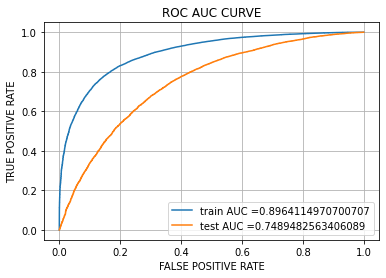

In [94]:
DT = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_samples_split=2, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method='gpu_hist', verbosity=1)
DT.fit(X_tr_set1, y_train)
y_train_pred1 = clf_1.predict_proba(X_tr_set1) [:,1]
y_test_pred1 = clf_1.predict_proba(X_te_set1) [:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred1)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("ROC AUC CURVE")
plt.grid()
plt.show()

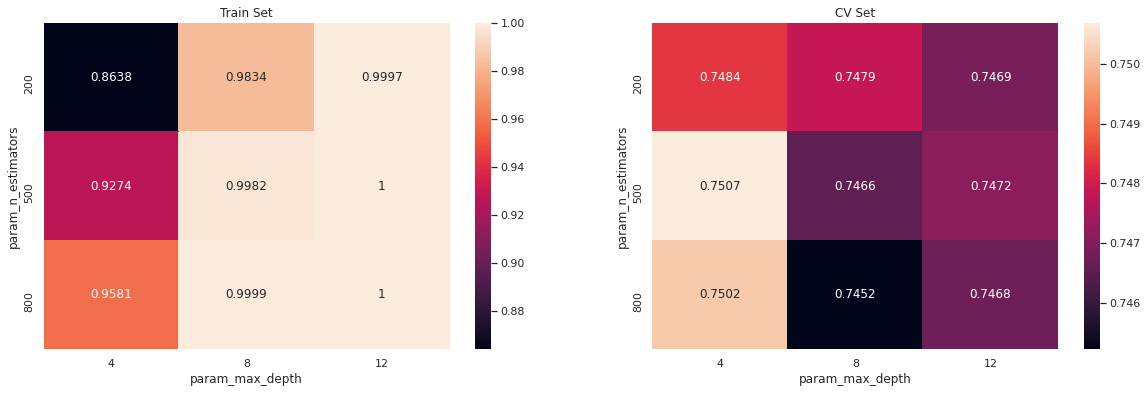

In [95]:
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf_1.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [96]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global predictions1
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1=predictions
    return predictions

In [97]:
print("*"*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred1, best_t)))

****************************************************************************************************
the maximum value of tpr*(1-fpr) 0.6670550280305062 for threshold 0.826
Train confusion matrix
[[ 9200  1883]
 [12200 49913]]
Test confusion matrix
[[ 3458  2001]
 [ 7754 22839]]


****************************************************************************************************
the maximum value of tpr*(1-fpr) 0.6670550280305062 for threshold 0.826


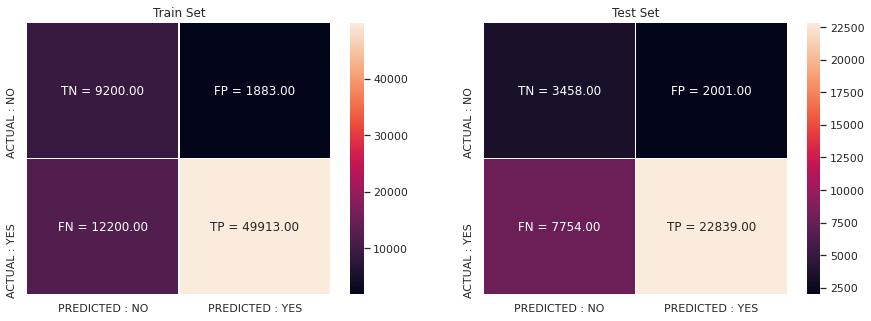

In [98]:
print("*"*100)
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
con_m_train=confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t))
con_m_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred1, best_t))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

## 1.7.2 GBDT On SET-2

### 1.7.2.1 Applying XGBOOST With GridSearchCV

In [99]:
n_estimators = [200, 300,500]
depth = [2,3,4]
parameters = {'max_depth': depth,'n_estimators':n_estimators}
GB_2 = xgb.XGBClassifier(tree_method='gpu_hist',learning_rate=0.1,random_state=0,min_samples_split=2)
clf_2 = GridSearchCV(GB_2, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf_2.fit(X_tr_set2, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     min_samples_split=2, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4],
         

In [105]:
print(clf_2.best_estimator_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, min_samples_split=2, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method='gpu_hist', verbosity=1)


### 1.7.2.2 Applying XGBOOST With Tuned Hyperparameters

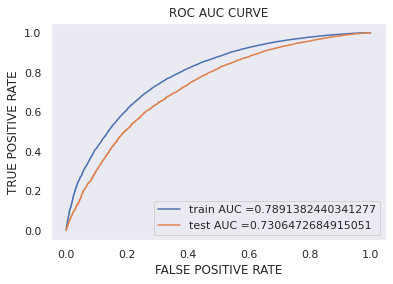

In [106]:
DT_2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, min_samples_split=2, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method='gpu_hist', verbosity=1)

DT_2.fit(X_tr_set2, y_train)
y_train_pred2 = clf_2.predict_proba(X_tr_set2) [:,1]
y_test_pred2 = clf_2.predict_proba(X_te_set2) [:,1]
train_fpr2, train_tpr2, tr_thresholds2 = roc_curve(y_train, y_train_pred2)
test_fpr2, test_tpr2, te_thresholds2 = roc_curve(y_test, y_test_pred2)

plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("ROC AUC CURVE")
plt.grid()
plt.show()

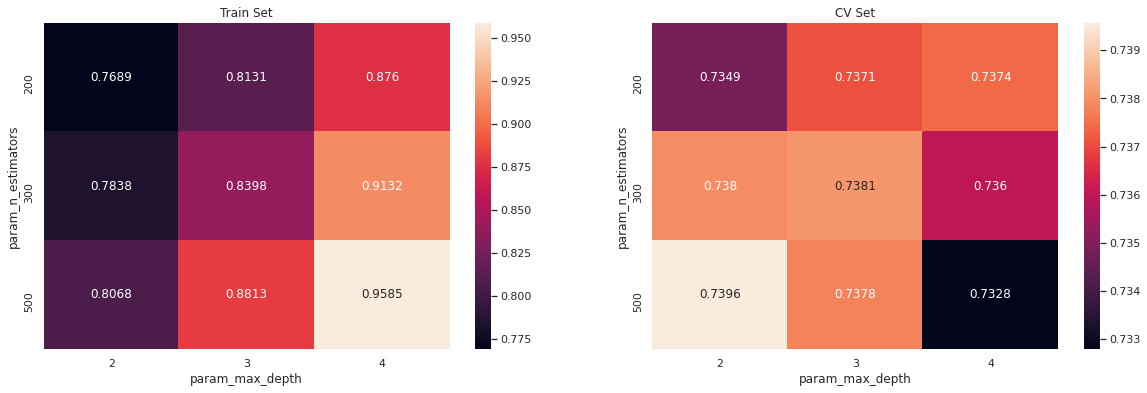

In [107]:
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(clf_2.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [108]:
print("*"*100)
from sklearn.metrics import confusion_matrix
best_t2 = find_best_threshold(tr_thresholds2, train_fpr2, train_tpr2)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred2, best_t2)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred2, best_t2)))

****************************************************************************************************
the maximum value of tpr*(1-fpr) 0.517273089046597 for threshold 0.833
Train confusion matrix
[[ 7851  3232]
 [16757 45356]]
Test confusion matrix
[[ 3590  1869]
 [ 9640 20953]]


the maximum value of tpr*(1-fpr) 0.517273089046597 for threshold 0.833


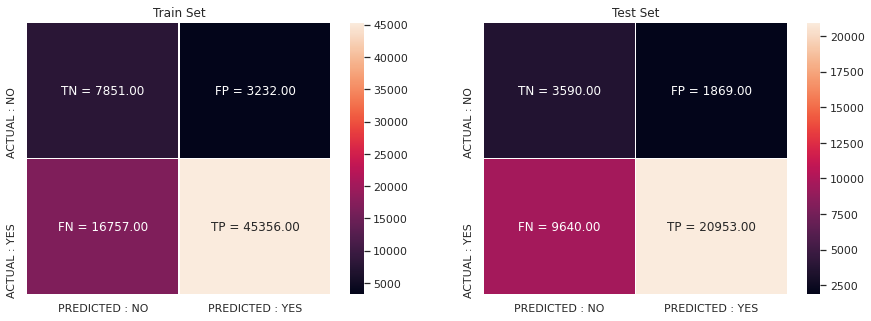

In [109]:
con_m_train=confusion_matrix(y_train, predict_with_best_t(y_train_pred2, best_t2))
con_m_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred2, best_t2))
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
best_t2 = find_best_threshold(tr_thresholds2, train_fpr2, train_tpr2)
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)
sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [111]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Vectorizer ", " Max_depth ", " N_ESTIMATORS "," Test -AUC " , "Train - AUc")
tb.add_row([" Tf - Idf", 4 , 500,74,89 ])
tb.add_row(["W2vec - Tf - Idf", 2 , 500 ,73,78])
print(tb.get_string(titles = "Decision trees- Observations"))

+------------------+-------------+----------------+-------------+-------------+
|    Vectorizer    |  Max_depth  |  N_ESTIMATORS  |  Test -AUC  | Train - AUc |
+------------------+-------------+----------------+-------------+-------------+
|     Tf - Idf     |      4      |      500       |      74     |      89     |
| W2vec - Tf - Idf |      2      |      500       |      73     |      78     |
+------------------+-------------+----------------+-------------+-------------+
